In [29]:
from __future__ import print_function, unicode_literals, absolute_import, division
import sys
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'


from glob import glob
from tqdm import tqdm
from tifffile import imread
from csbdeep.utils import Path, normalize
from csbdeep.utils.plot_utils import *
from csbdeep.data.transform import Transform

from stardist import fill_label_holes, random_label_cmap, calculate_extents, gputools_available
from stardist.models import Config2D, StarDist2D, StarDistData2D
from stardist.models.sample_patches import sample_patches

import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

np.random.seed(42)
lbl_cmap = random_label_cmap()

%reload_ext autoreload
%autoreload 2

## Load sample data

In [2]:
# !pip install albumentations

In [31]:
X = sorted(glob('/home/qzt/data/dsb2018_sub1/images/*.tif'))
Y = sorted(glob('/home/qzt/data/dsb2018_sub1/masks/*.tif'))
assert all(Path(x).name==Path(y).name for x,y in zip(X,Y))

X = list(map(imread,X))
Y = list(map(imread,Y))
n_channel = 1 if X[0].ndim == 2 else X[0].shape[-1]

axis_norm = (0,1)   # normalize channels independently
# axis_norm = (0,1,2) # normalize channels jointly
if n_channel > 1:
    print("Normalizing image channels %s." % ('jointly' if axis_norm is None or 2 in axis_norm else 'independently'))
    sys.stdout.flush()

X = [normalize(x,1,99.8,axis=axis_norm) for x in tqdm(X)]
Y = [fill_label_holes(y) for y in tqdm(Y)]

100%|██████████| 292/292 [00:01<00:00, 218.51it/s]


In [32]:
assert len(X) > 1, "not enough training data"
rng = np.random.RandomState(42)
ind = rng.permutation(len(X))
n_val = max(1, int(round(0.15 * len(ind))))
ind_train, ind_val = ind[:-n_val], ind[-n_val:]

#manual assign train/val index for debugging
# ind_train = [1,2,3,4]
# ind_val = [0]

X_val, Y_val = [X[i] for i in ind_val]  , [Y[i] for i in ind_val]
X_trn, Y_trn = [X[i] for i in ind_train], [Y[i] for i in ind_train] 
print('number of images: %3d' % len(X))
print('- training:       %3d' % len(X_trn))
print('- validation:     %3d' % len(X_val))

number of images: 292
- training:       248
- validation:      44


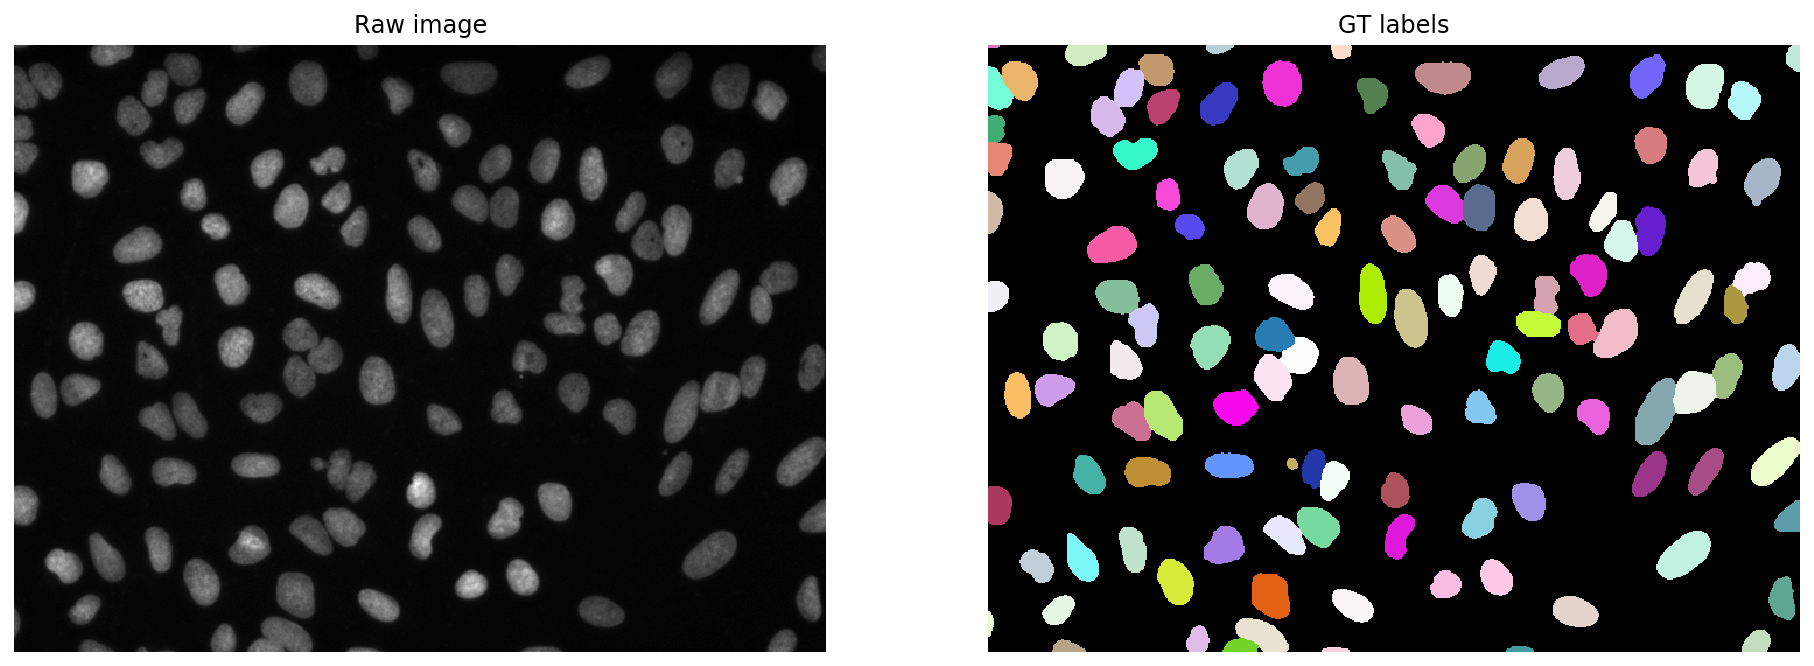

In [38]:
i = 5
# img, lbl = X[i], Y[i]
img, lbl = X_val[i], Y_val[i]
assert img.ndim in (2,3)
img = img if (img.ndim==2 or img.shape[-1]==3) else img[...,0]
plt.figure(figsize=(16,10))
plt.subplot(121); plt.imshow(img,cmap='gray');   plt.axis('off'); plt.title('Raw image')
plt.subplot(122); plt.imshow(lbl,cmap=lbl_cmap); plt.axis('off'); plt.title('GT labels')
None;

In [39]:
img.shape

(520, 696)

## Try with other augmentation packages and use stardist generator pipe (keras sequence) 

In [40]:
# import cv2
from albumentations import *

In [42]:
AUGMENTATIONS_TRAIN = Compose([
    Flip(p=0.5),
#     Rotate(p=1, interpolation=0),
#     RandomScale(scale_limit=0.5, interpolation=1, always_apply=True, p=0.9),
#     Downscale(scale_min = 0.8, scale_max=0.5, p=0.5),
    ShiftScaleRotate(shift_limit=0.0, scale_limit=0.2, rotate_limit=90, interpolation=0, border_mode=4, value=None, mask_value=None, always_apply=False, p=0.5)
])

In [47]:
data_train = StarDistData2D(X_trn, Y_trn, batch_size=4, n_rays=32, patch_size=(256,256), augmenter=AUGMENTATIONS_TRAIN, shape_completion=False)

In [48]:
type(data_train[0])

tuple

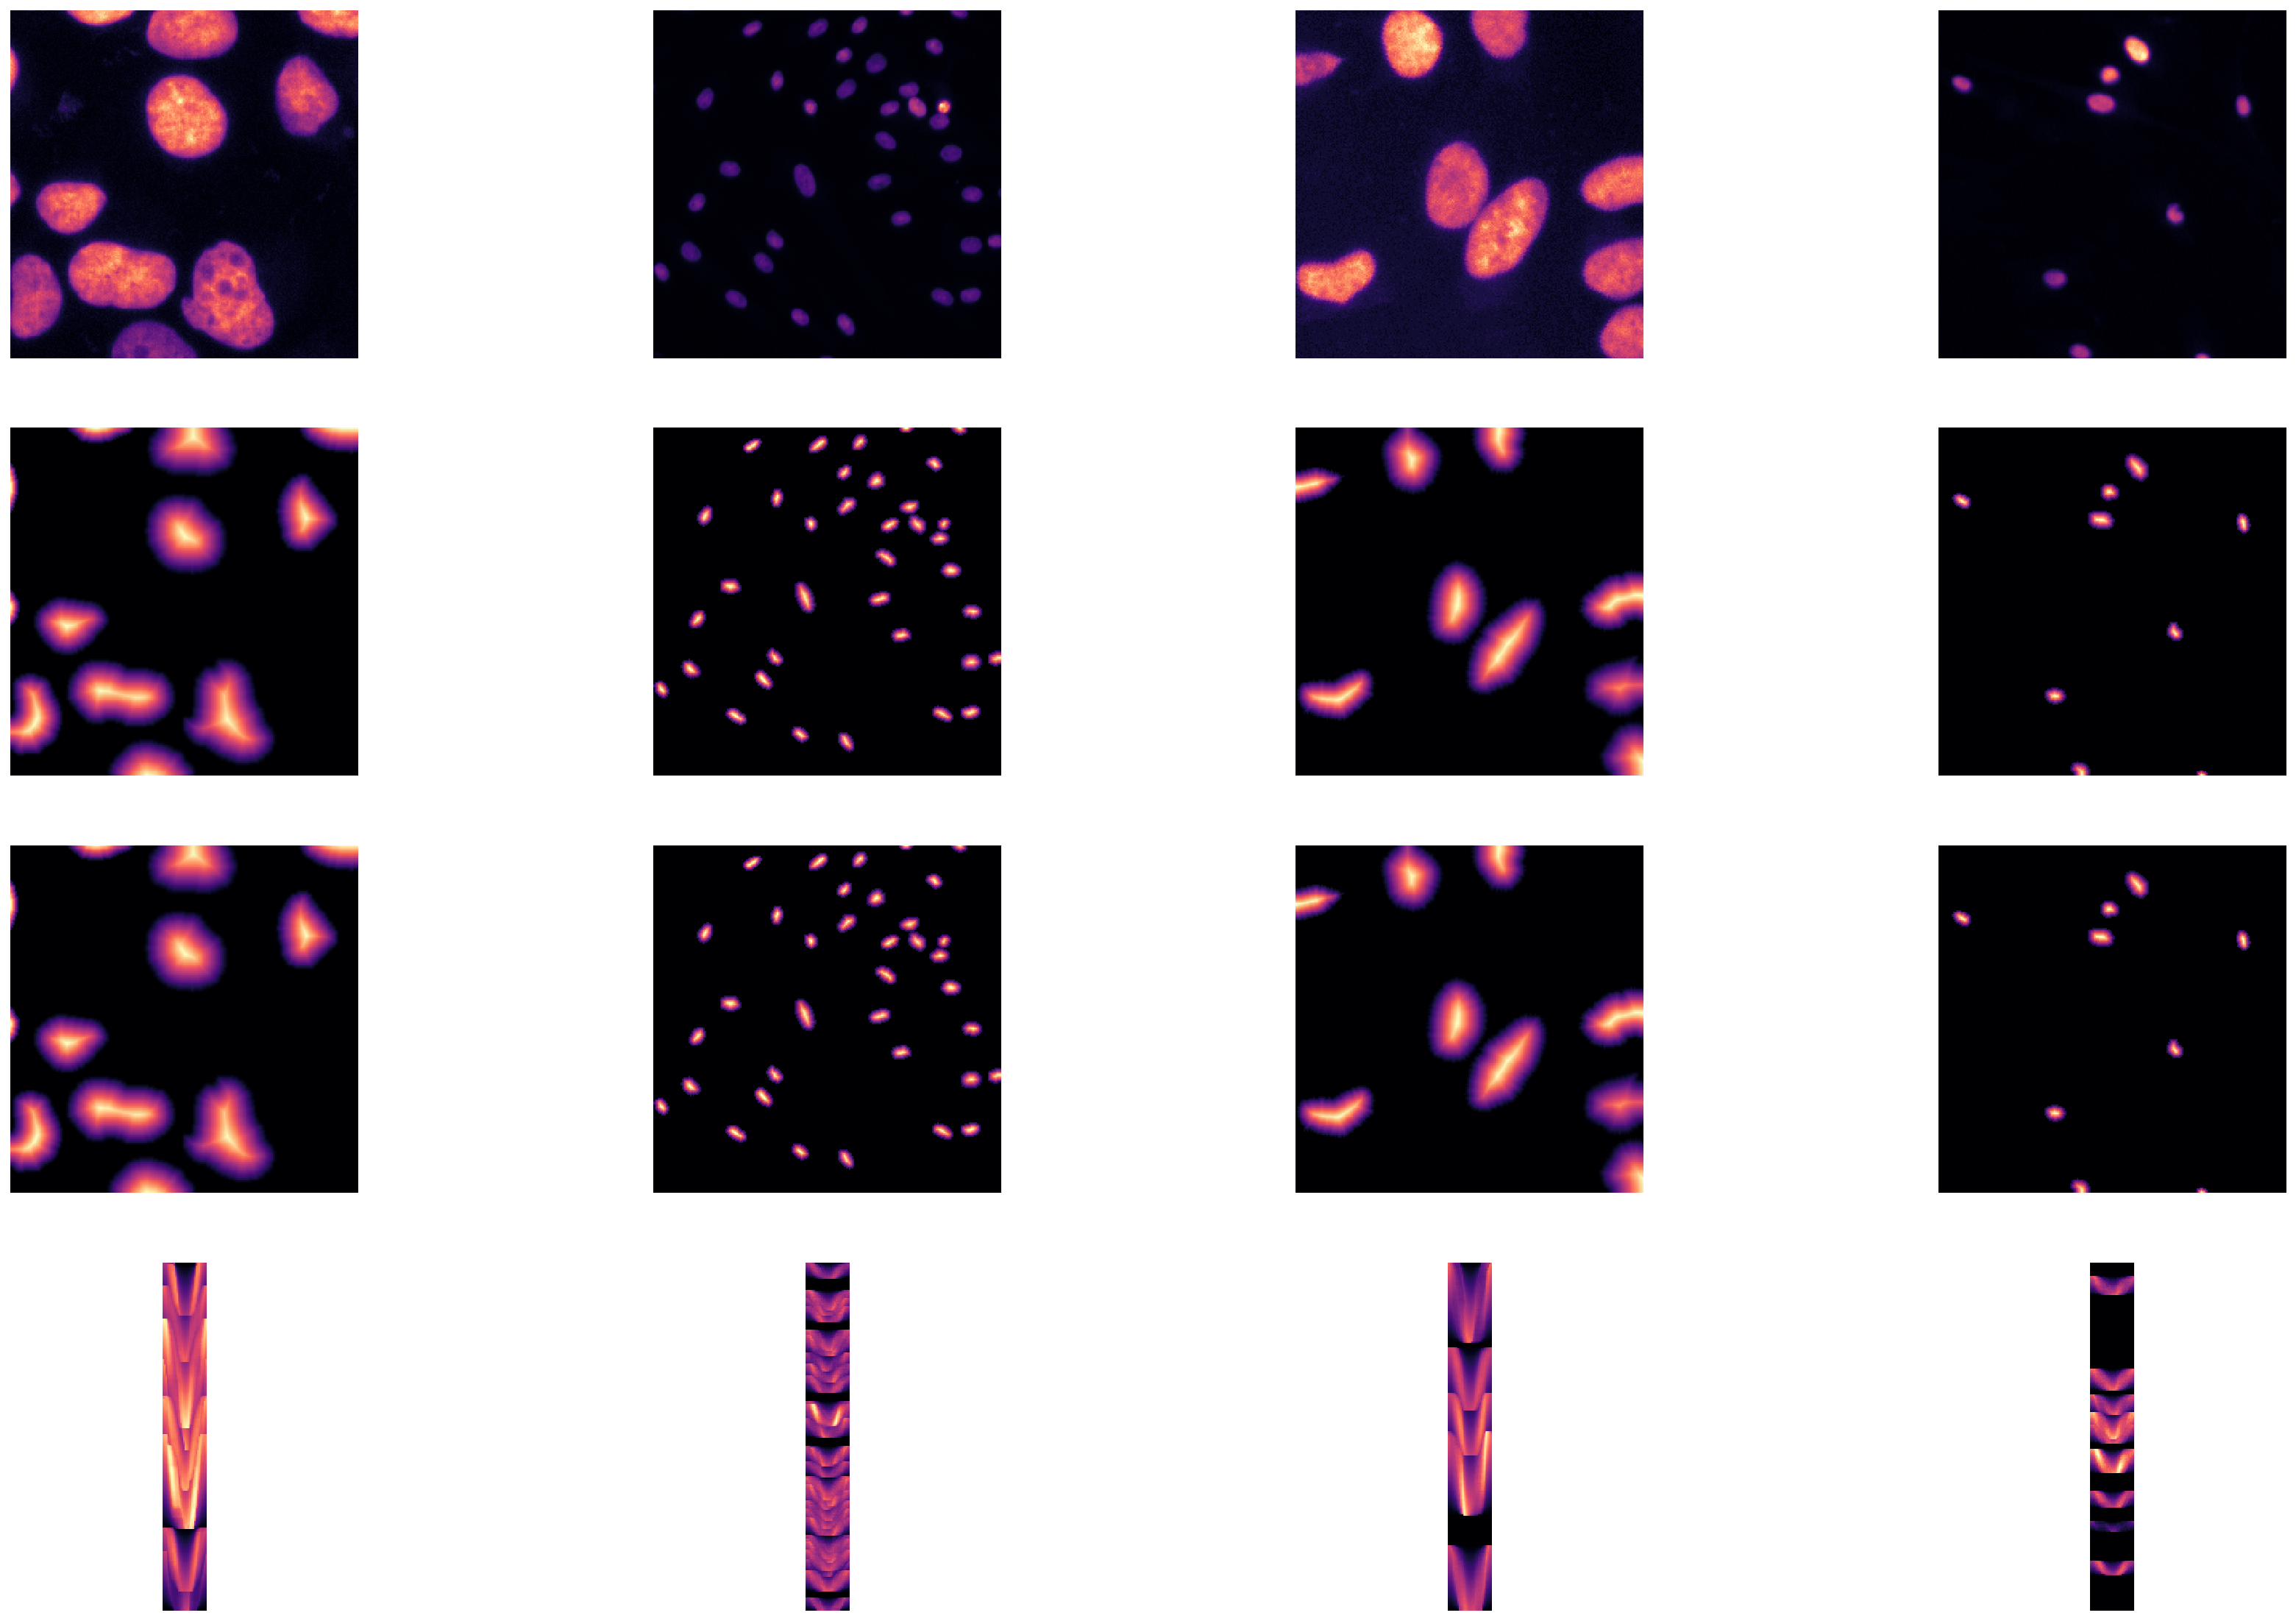

In [54]:
XX, YY = data_train[5]

X,dist_mask = XX
prob,dist = YY

plot_some(X, dist_mask, prob, dist, x_inch=30, y_inch=20)

## Debug validation data part

In [15]:
validation_data=(X_val,Y_val)
data_kwargs = {'n_rays': 32, 'patch_size': (256, 256), 'grid': (2, 2), 'shape_completion': False, 'b': 32, 'use_gpu': False, 'foreground_prob': 0.9}
data_val = StarDistData2D(*validation_data, batch_size=1, **data_kwargs)

data_val[0][0][0].shape

(1, 256, 256, 1)

## Train with augmentations

In [58]:
# 32 is a good default choice (see 1_data.ipynb)
n_rays = 32

# Use OpenCL-based computations for data generator during training (requires 'gputools')
use_gpu = False and gputools_available()

# Predict on subsampled grid for increased efficiency and larger field of view
grid = (2,2)

conf = Config2D (
    n_rays       = n_rays,
    grid         = grid,
    use_gpu      = use_gpu,
    n_channel_in = n_channel,
    train_batch_size = 1,  #no gpu
    train_epochs = 200,
    train_steps_per_epoch = 100,
#     net_input_shape = (X_trn[0].shape[0], X_trn[0].shape[1], n_channel)
)

conf

Config2D(axes='YXC', backbone='unet', grid=(2, 2), n_channel_in=1, n_channel_out=33, n_dim=2, n_rays=32, net_conv_after_unet=128, net_input_shape=(None, None, 1), net_mask_shape=(None, None, 1), train_background_reg=0.0001, train_batch_size=1, train_checkpoint='weights_best.h5', train_checkpoint_epoch='weights_now.h5', train_checkpoint_last='weights_last.h5', train_completion_crop=32, train_dist_loss='mae', train_epochs=200, train_foreground_only=0.9, train_learning_rate=0.0003, train_loss_weights=(1, 0.2), train_n_val_patches=None, train_patch_size=(256, 256), train_reduce_lr={'factor': 0.5, 'patience': 40, 'min_delta': 0}, train_shape_completion=False, train_steps_per_epoch=100, train_tensorboard=True, unet_activation='relu', unet_batch_norm=False, unet_dropout=0.0, unet_kernel_size=(3, 3), unet_last_activation='relu', unet_n_conv_per_depth=2, unet_n_depth=3, unet_n_filter_base=32, unet_pool=(2, 2), unet_prefix='', use_gpu=False)

In [66]:
model = StarDist2D(conf, name='stardist_select', basedir='exp_3')

Using default values: prob_thresh=0.5, nms_thresh=0.4.


In [67]:
# %debug
model.train(X_trn, Y_trn, validation_data=(X_val,Y_val), augmenter=None)

Epoch 1/200
100/100 [==============================] - 23s 228ms/step - loss: 1.9205 - prob_loss: 0.3872 - dist_loss: 7.6668 - prob_kld: 0.3229 - dist_relevant_mae: 7.6664 - dist_relevant_mse: 128.0282 - val_loss: 1.9214 - val_prob_loss: 0.4206 - val_dist_loss: 7.5041 - val_prob_kld: 0.3336 - val_dist_relevant_mae: 7.5036 - val_dist_relevant_mse: 134.2991
Epoch 2/200
100/100 [==============================] - 23s 230ms/step - loss: 1.7691 - prob_loss: 0.4188 - dist_loss: 6.7514 - prob_kld: 0.3304 - dist_relevant_mae: 6.7506 - dist_relevant_mse: 98.0306 - val_loss: 1.5615 - val_prob_loss: 0.3404 - val_dist_loss: 6.1053 - val_prob_kld: 0.2534 - val_dist_relevant_mae: 6.1045 - val_dist_relevant_mse: 85.5774
Epoch 3/200
100/100 [==============================] - 22s 224ms/step - loss: 1.4950 - prob_loss: 0.3222 - dist_loss: 5.8640 - prob_kld: 0.2391 - dist_relevant_mae: 5.8631 - dist_relevant_mse: 76.7608 - val_loss: 1.4666 - val_prob_loss: 0.3056 - val_dist_loss: 5.8050 - val_prob_kld: 0.

In [62]:
model.keras_model.save('exp2_1b_100s_200e.h5')

In [22]:
model.train(X_trn, Y_trn, validation_data=(X_val,Y_val), augmenter=AUGMENTATIONS_TRAIN)

Epoch 1/200
100/100 [==============================] - 23s 232ms/step - loss: 0.3942 - prob_loss: 0.0955 - dist_loss: 1.4935 - prob_kld: 0.0110 - dist_relevant_mae: 1.4930 - dist_relevant_mse: 8.6116 - val_loss: 0.3463 - val_prob_loss: 0.0801 - val_dist_loss: 1.3311 - val_prob_kld: 0.0085 - val_dist_relevant_mae: 1.3306 - val_dist_relevant_mse: 7.1671
Epoch 2/200
100/100 [==============================] - 23s 230ms/step - loss: 0.3897 - prob_loss: 0.0817 - dist_loss: 1.5400 - prob_kld: 0.0114 - dist_relevant_mae: 1.5395 - dist_relevant_mse: 9.9819 - val_loss: 0.3468 - val_prob_loss: 0.0802 - val_dist_loss: 1.3328 - val_prob_kld: 0.0086 - val_dist_relevant_mae: 1.3323 - val_dist_relevant_mse: 6.4148
Epoch 3/200
100/100 [==============================] - 24s 237ms/step - loss: 0.3966 - prob_loss: 0.0800 - dist_loss: 1.5830 - prob_kld: 0.0091 - dist_relevant_mae: 1.5825 - dist_relevant_mse: 10.1022 - val_loss: 0.3527 - val_prob_loss: 0.0795 - val_dist_loss: 1.3662 - val_prob_kld: 0.0079 -

In [23]:
model.keras_model.save('1b_100s_400e.h5') 

In [22]:
model.keras_model.load_weights('1b_100s_400e.h5')

In [23]:
model.keras_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, None, None, 1 0                                            
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, None, None, 3 320         input[0][0]                      
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, None, None, 3 9248        conv2d_3[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_2 (MaxPooling2D)  (None, None, None, 3 0           conv2d_4[0][0]                   
____________________________________________________________________________________________

# Threshold optimization

While the default values for the probability and non-maximum suppression thresholds already yield good results in many cases, we still recommend to adapt the thresholds to your data. The optimized threshold values are saved to disk and will be automatically loaded with the model.

In [68]:
model.optimize_thresholds(X_val, Y_val)

NMS threshold = 0.5:  80%|████████  | 16/20 [00:21<00:05,  1.34s/it, 0.489 -> 0.875]


Using optimized values: prob_thresh=0.487764, nms_thresh=0.3.
Saving to 'thresholds.json'.


{'prob': 0.4877641177617973, 'nms': 0.3}

In [64]:
%pwd

'/home/qzt/stardist/examples/2D'

In [69]:
model.export_TF(fname='select_aug3')

In [ ]:
# export_TF(self, fname=None, single_output=True, upsample_grid=True)
# tf.saved_model.save(model, "/home/qzt/data/")